In [1]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import to_categorical, plot_model
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

EDA (Exploratory Data Analysis)

In [3]:
# Checking the number of rows (records) and columns (features)
print("Train Image Shape ".ljust(20, "-"), train_images.shape)
print("Train Label Shape ".ljust(20, "-"),train_labels.shape)
print("Test Image Shape ".ljust(20, "-"),test_images.shape)
print("Test Label Shape ".ljust(20, "-"),test_labels.shape)

Train Image Shape -- (50000, 32, 32, 3)
Train Label Shape -- (50000, 1)
Test Image Shape --- (10000, 32, 32, 3)
Test Label Shape --- (10000, 1)


In [4]:
print("Unique Train Labels ".ljust(24, "-"), np.unique(train_labels))
print("Unique Test Labels ".ljust(24, "-"), np.unique(test_labels))

Unique Train Labels ---- [0 1 2 3 4 5 6 7 8 9]
Unique Test Labels ----- [0 1 2 3 4 5 6 7 8 9]


In [5]:
# A list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

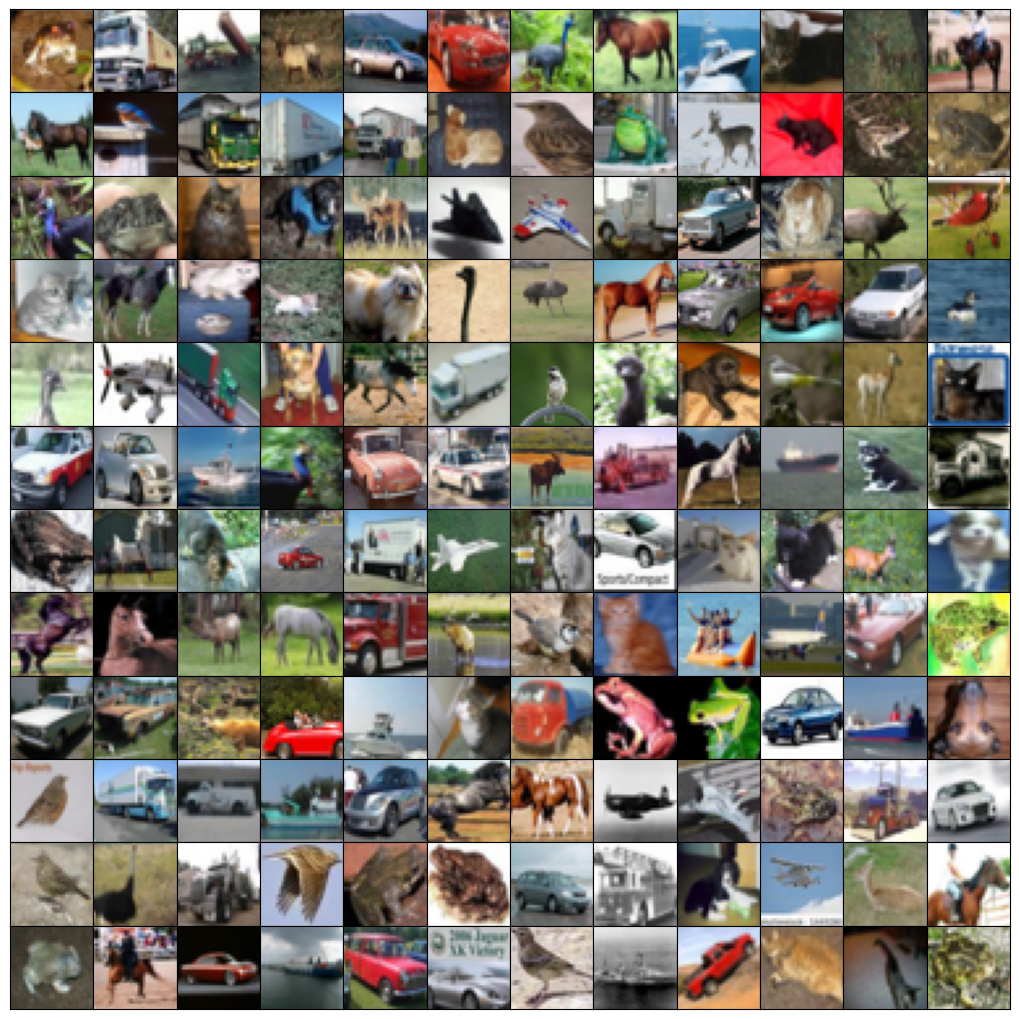

In [7]:
# Visualizing some of the images from the training dataset
fig = plt.figure(figsize=[10,10])
for i in range(144):
  plt.subplot(12, 12, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)

plt.subplots_adjust(wspace=0, hspace=0, left=0, top=1, bottom=0, right=1)
# plt.subplots_adjust(top=)
plt.show()

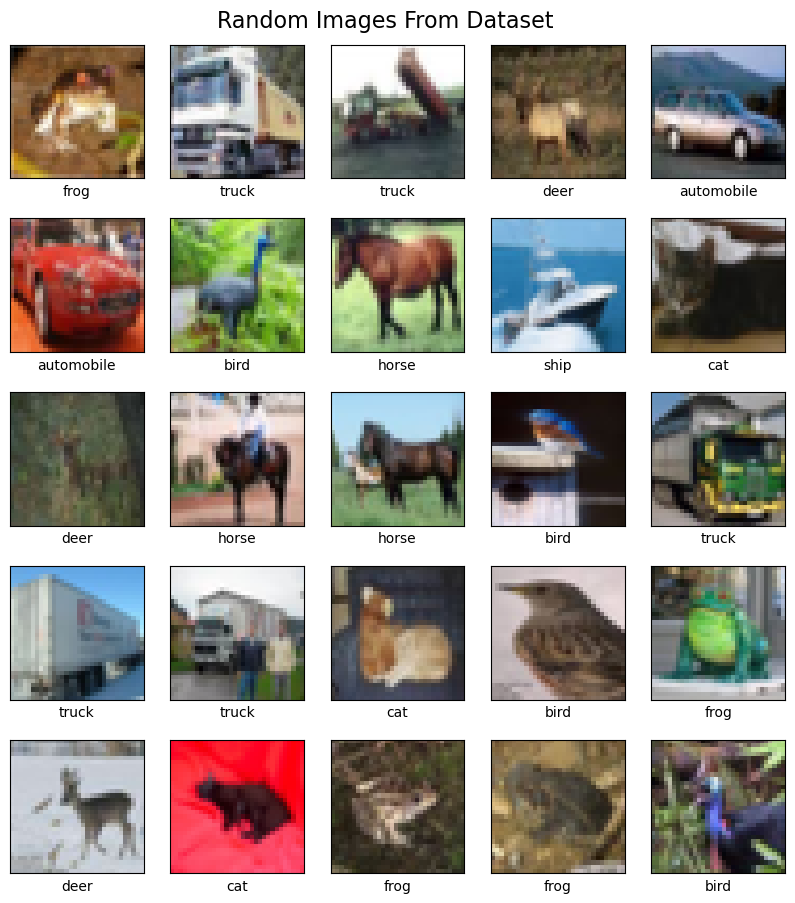

In [8]:
# Visualizing some of the images from the training dataset
fig = plt.figure(figsize=[10,10])
fig.suptitle('Random Images From Dataset', fontsize=16)  # Add global title
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i][0]])

plt.subplots_adjust(top=0.95)
plt.show()

Data Preprocessing
- convert all pixel values to values between 0 and 1.
- one hot encoding (target classes)

In [9]:
# Converting the pixels data to float type
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Standardizing (255 is the total number of pixels an image can have)
train_images = train_images / 255
test_images = test_images / 255 

# One hot encoding the target class (labels)
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [10]:
# Creating a sequential model and adding layers to it

model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Checking the model summary
# model.summary()
plot_model(model);

2024-01-29 03:38:41.965793: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-29 03:38:41.965827: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-29 03:38:41.965833: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-29 03:38:41.966075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-29 03:38:41.966295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
loss_fn = keras.losses.categorical_crossentropy
optimizer=keras.optimizers.legacy.Adam()

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=["accuracy"])

In [31]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               rotation_range=15,
                               width_shift_range=0.1,   # Randomly shift images horizontally by up to 10% of the width
                               height_shift_range=0.1,
                               vertical_flip=True,
                               horizontal_flip=True,
                               fill_mode='nearest'
                               )
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, shuffle=True)
validation_generator = train_datagen.flow(test_images, test_labels, batch_size=128, shuffle=True)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/100
390/390 [==============================] - 14s 36ms/step - loss: 1.3520 - accuracy: 0.5118 - val_loss: 2.0709 - val_accuracy: 0.2999
Epoch 2/100
390/390 [==============================] - 14s 36ms/step - loss: 1.3024 - accuracy: 0.5332 - val_loss: 1.3471 - val_accuracy: 0.5066
Epoch 3/100
390/390 [==============================] - 14s 36ms/step - loss: 1.2591 - accuracy: 0.5489 - val_loss: 4.2777 - val_accuracy: 0.1367
Epoch 4/100
390/390 [==============================] - 15s 37ms/step - loss: 1.2134 - accuracy: 0.5650 - val_loss: 2.5400 - val_accuracy: 0.2189
Epoch 5/100
390/390 [==============================] - 15s 37ms/step - loss: 1.1806 - accuracy: 0.5763 - val_loss: 1.3537 - val_accuracy: 0.5046
Epoch 6/100
390/390 [==============================] - 15s 39ms/step - loss: 1.1634 - accuracy: 0.5871 - val_loss: 1.5431 - val_accuracy: 0.4648
Epoch 7/100
390/390 [==============================] - 19s 48ms/step - loss: 1.1353 - accuracy: 0.5959 - val_loss: 2.1704 - val_ac

: 

In [ ]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)
plt.savefig("Loss curve")

In [ ]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)
plt.savefig("Accuracy curve")

In [ ]:
def make_prediction(model, data, labels):
    # Making the Predictions
    pred = model.predict(data)
    # Converting the predictions into label index 
    pred_classes = np.argmax(pred, axis=1)
    
    accuracy = (np.argmax(labels, axis=1) == pred_classes)
    return accuracy.sum()/len(accuracy)


In [ ]:
train_acc = make_prediction(model, train_images, train_labels)
test_acc = make_prediction(model, test_images, test_labels)
print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")


In [ ]:
# Plotting the Actual vs. Predicted results

fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(test_images[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[np.argmax(test_labels[i])], class_names[pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

# Save model

In [ ]:
import tensorflow as tf

model.save("saved_model")
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

with open("model_cpu.tflite", "wb") as f:
    f.write(tflite_model)


# Load Model

In [ ]:
import tensorflow as tf
from keras.datasets import cifar10
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
test_images = test_images.astype('float32')
test_images = test_images / 255 

interpreter = tf.lite.Interpreter(model_path="model_cpu.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()